In [1]:
# Copyright 2025 International Business Machines

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#  http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview
This notebook focuses on finetuning the [terramind model](https://huggingface.co/collections/ibm-esa-geospatial/terramind-10-68063b522bfbeda3498aeafe) to identify floods in a sentinel scene. The main takeaways from this notebook will be as follows:
1. Learn how to use Terratorch to fine-tune terramind for floods in sentinel scene.
2. Understand the effects of specific parameters in training and hardware utilization.
3. Use fine-tuned model for inference.

## Setup
1. Install terratorch - To install the necessary packages, execute the cell below. This will take a few minutes. Once the installation process is done, a window will pop up to ask you to restart the session. This is normal and you should proceed to restart using the interface in the pop up window.


In [2]:
!pip install terratorch==1.0.2 gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.6/851.6 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. Import dependencies

In [3]:
import os
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

3. Download the dataset from Google Drive. This should take a few minutes. Sen1Floods11 is a surface water data set including classified permanent water, flood water, and raw Sentinel-1 imagery. The full dataset consists of 4,831 labeled 512x512 chips that span all 14 biomes, 357 ecoregions, and 6 continents of the world across 11 flood events. To learn more about the dataset used in this notebook, take a look at the Sen1Floods11 [github page](https://github.com/cloudtostreet/Sen1Floods11?tab=readme-ov-file) and associated [publication](https://openaccess.thecvf.com/content_CVPRW_2020/html/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.html).



In [4]:
!mkdir ../data/
if not os.path.isfile("../data/sen1floods11_v1.1.tar.gz"):
    gdown.download("https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS", '../data/sen1floods11_v1.1.tar.gz')

!tar -xzf ../data/sen1floods11_v1.1.tar.gz -C ../data/

Downloading...
From (original): https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS
From (redirected): https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS&confirm=t&uuid=38b87347-052b-44c4-a3ce-29d9f906f688
To: /data/sen1floods11_v1.1.tar.gz
100%|██████████| 1.75G/1.75G [00:17<00:00, 98.1MB/s]


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'SCHILY.

## Sen1Floods11 Dataset

Lets start with analysing the dataset

In [5]:
dataset_path = Path("../data/sen1floods11_v1.1")
!ls "../data/sen1floods11_v1.1/data"

LabelHand  S1GRDHand  S2L1CHand


In [6]:
!ls "../data/sen1floods11_v1.1/data/S2L1CHand/" | head

Bolivia_103757_S2Hand.tif
Bolivia_129334_S2Hand.tif
Bolivia_195474_S2Hand.tif
Bolivia_23014_S2Hand.tif
Bolivia_233925_S2Hand.tif
Bolivia_242570_S2Hand.tif
Bolivia_290290_S2Hand.tif
Bolivia_294583_S2Hand.tif
Bolivia_312675_S2Hand.tif
Bolivia_314919_S2Hand.tif


TerraTorch provides generic data modules that work directly with PyTorch Lightning.

Sen1Floods11 is a multimodal dataset that provides Sentinel-2 L2A and Sentinel-1 GRD data.
Therefore, we are using the `GenericMultiModalDataModule`.
This module is similar to the `GenericNonGeoSegmentationDataModule`, which is used for standard segmentation tasks.
However, the data roots, `img_grep` are other settings are provided as dict to account for the multimodal inputs. You find all settings in the [documentation](https://ibm.github.io/terratorch/stable/generic_datamodules/).
In a Lightning config, the data module is defined with the `data` key.

In [7]:
data_mean = {
    "S2L1C": [2357.089, 2137.385, 2018.788, 2082.986, 2295.651, 2854.537, 3122.849, 3040.560, 3306.481, 1473.847, 506.070, 2472.825, 1838.929],
    "S2L2A": [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648],
    "S1GRD": [-12.599, -20.293],
    "S1RTC": [-10.93, -17.329],
    "RGB": [87.271, 80.931, 66.667],
    "DEM": [670.665]
}

data_stds = {
    "S2L1C": [1624.683, 1675.806, 1557.708, 1833.702, 1823.738, 1733.977, 1732.131, 1679.732, 1727.26, 1024.687, 442.165, 1331.411, 1160.419],
    "S2L2A": [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311],
    "S1GRD": [5.195, 5.890],
    "S1RTC": [4.391, 4.459],
    "RGB": [58.767, 47.663, 42.631],
    "DEM": [951.272],
}

datamodule = terratorch.datamodules.GenericMultiModalDataModule(
    task="segmentation",
    batch_size=4,
    num_workers=2,
    num_classes=2,

    # Define your input modalities. The names must match the keys in the following dicts.
    modalities=["S2L1C", "S1GRD"],
    rgb_modality="S2L1C",  # Used for plotting. Defaults to the first modality if not provided.
    rgb_indices=[3,2,1],  # RGB channel positions in the rgb_modality.

    # Define data paths as dicts using the modality names as keys.
    train_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    train_label_data_root=dataset_path / "data/LabelHand",
    val_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    val_label_data_root=dataset_path / "data/LabelHand",
    test_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    test_label_data_root=dataset_path / "data/LabelHand",

    # Define split files because all samples are saved in the same folder.
    train_split=dataset_path / "splits/flood_train_data.txt",
    val_split=dataset_path / "splits/flood_valid_data.txt",
    test_split=dataset_path / "splits/flood_test_data.txt",

    # Define suffix, again using dicts.
    img_grep={
        "S2L1C": "*_S2Hand.tif",
        "S1GRD": "*_S1Hand.tif",
    },
    label_grep="*_LabelHand.tif",

    # With TerraTorch, you can select a subset of the dataset bands as model inputs by providing dataset_bands (all bands in the data) and output_bands (selected bands). This setting is optional for all modalities and needs to be provided as dicts.
    # Here is an example for with S-1 GRD. You could change the output to ["VV"] to only train on the first band. Note that means and stds must be aligned with the output_bands (equal length of values).
    dataset_bands={
        "S1GRD": ["VV", "VH"]
    },
    output_bands={
        "S1GRD": ["VV", "VH"]
    },

    # Define standardization values. We use the pre-training values here and providing the additional modalities is not a problem, which makes it simple to experiment with different modality combinations. Alternatively, use the dataset statistics that you can generate using `terratorch compute_statistics -c config.yaml` (requires concat_bands: true for this multimodal datamodule).
    means=data_mean,
    stds=data_stds,

        # albumentations supports shared transformations and can handle multimodal inputs.
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensorV2() by default if not provided
    test_transform=None,

    no_label_replace=-1,  # Replace NaN labels. defaults to -1 which is ignored in the loss and metrics.
    no_data_replace=0,  # Replace NaN data
)

# Setup train and val datasets
datamodule.setup("fit")

In [8]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

89

In [9]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

90

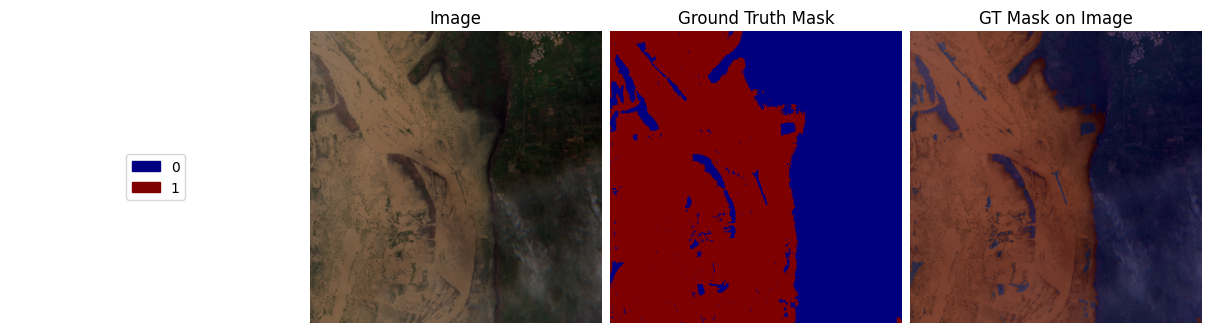

In [10]:
# plotting a sample (The code only plots the defined `rgb_modality`)
val_dataset.plot(val_dataset[2])
plt.show()

In [11]:
# Helper function for plotting both modalities
def plot_sample(sample):
    s1 = sample['image']['S1GRD'].cpu().numpy()
    s2 = sample['image']['S2L1C'].cpu().numpy()
    mask = sample['mask'].cpu().numpy()

    # Scaling data. Using -30 to 0 scaling for S-1 and 0 - 2000 for S-2. S-1 is visualized as [VH, VV, VH]
    s1 = (s1.clip(-30, 0) / 30 + 1) * 255
    s2 = (s2.clip(0, 2000) / 2000) * 255
    s1_rgb = np.stack([s1[1], s1[0], s1[1]], axis=0).astype(np.uint8).transpose(1,2,0)
    s2_rgb = s2[[3,2,1]].astype(np.uint8).transpose(1,2,0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(s1_rgb)
    ax[0].set_title('S-1 GRD')
    ax[0].axis('off')
    ax[1].imshow(s2_rgb)
    ax[1].set_title('S-2 GRD')
    ax[1].axis('off')
    ax[2].imshow(mask, vmin=-1, vmax=1, interpolation='nearest')
    ax[2].set_title('Mask')
    ax[2].axis('off')
    fig.tight_layout()
    plt.show()

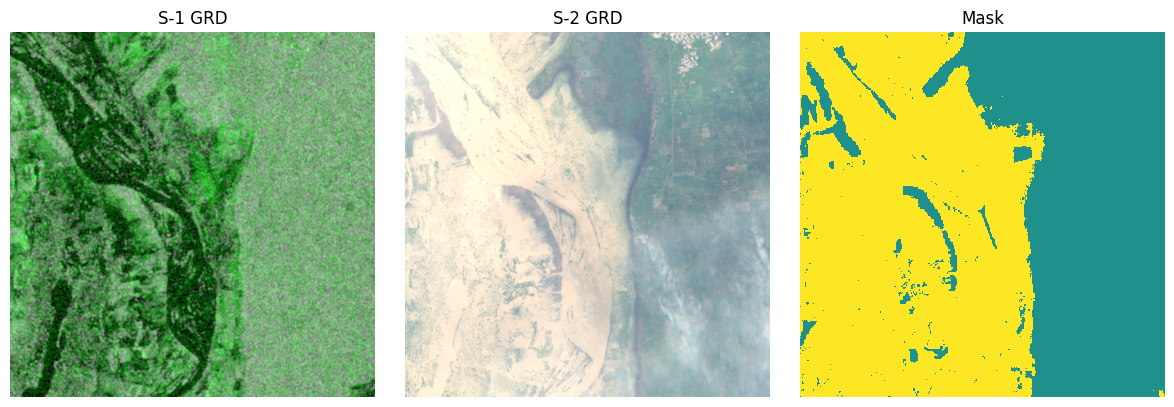

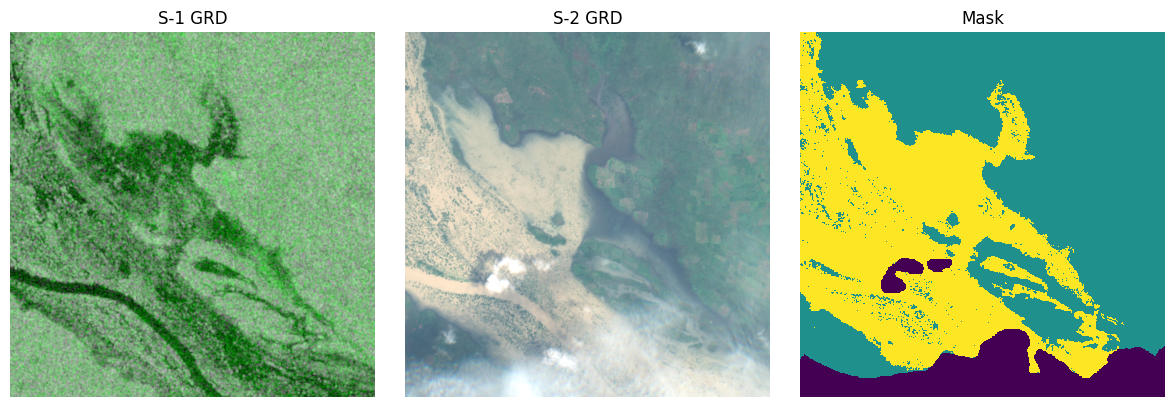

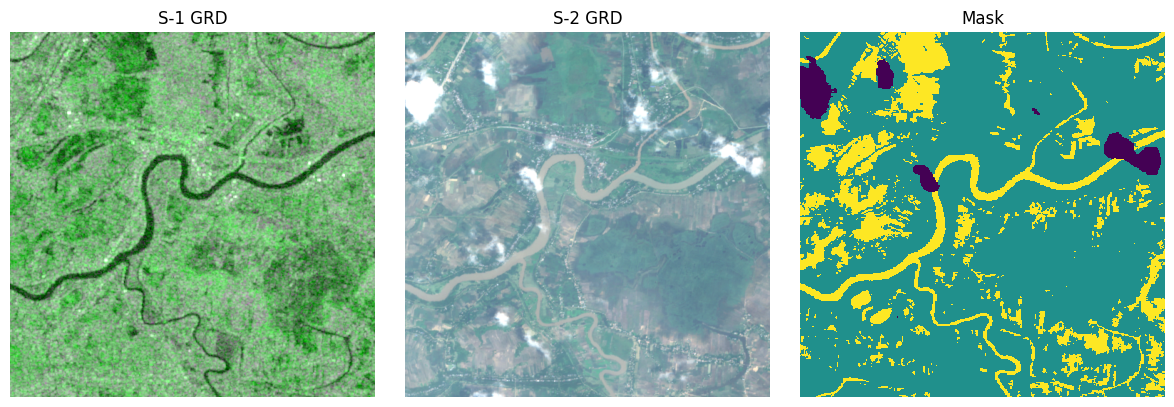

In [12]:
plot_sample(val_dataset[2])
plot_sample(val_dataset[8])
plot_sample(val_dataset[11])

# TerraTorch model registry

TerraTorch includes its own backbone registry with many EO FMs. It also includes meta registries for all model components that include other sources like timm image models or SMP decoders.

In [13]:
from terratorch.registry import BACKBONE_REGISTRY, TERRATORCH_BACKBONE_REGISTRY, TERRATORCH_DECODER_REGISTRY

In [14]:
# Print all TerraMind v1 backbones.
[backbone
 for backbone in TERRATORCH_BACKBONE_REGISTRY
 if 'terramind_v1' in backbone]
# TiM models are using the Thinking-in-Modalities approach, see our paper for details https://arxiv.org/html/2504.11171v1.

['terramind_v1_base',
 'terramind_v1_base_tim',
 'terramind_v1_large',
 'terramind_v1_large_tim']

In [15]:
# Available decoders. We use the UNetDecoder in this example.
list(TERRATORCH_DECODER_REGISTRY)

['FCNDecoder',
 'IdentityDecoder',
 'SatMAEHead',
 'UperNetDecoder',
 'ASPPModule',
 'ASPPHead',
 'ASPPSegmentationHead',
 'ASPPRegressionHead',
 'MLPDecoder',
 'UNetDecoder',
 'LinearDecoder']

In [16]:
# Use the backbone registry to load a PyTorch model for custom pipeline. The pre-trained weights are automatically downloaded with pretrained=True.
model = BACKBONE_REGISTRY.build(
    "terramind_v1_base",
    modalities=["S2L1C", "S1GRD"],
    pretrained=True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


TerraMind_v1_base.pt:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [17]:
model

TerraMindViT(
  (encoder_embeddings): ModuleDict(
    (untok_sen2l1c@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=3328, out_features=768, bias=False)
    )
    (untok_sen1grd@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=512, out_features=768, bias=False)
    )
  )
  (encoder): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm()
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm()
      (mlp): GatedMlp(
        (fc1): Linear(in_features=768, out_features=2048, bias=False)
        (act): SiLU()
        (fc2): Linear(in_features=2048, out_features=768, bias=False)
        (fc3): Linear(in_features=768, out_features=2048, bias=False)
      )
    )
  )
  (encoder_norm): La

# Fine-tune TerraMind via PyTorch Lightning

With TerraTorch, we can use standard Lightning components for the fine-tuning.
These include callbacks and the trainer class.

TerraTorch provides EO-specific tasks that define the training and validation steps.
In this case, we are using the `SemanticSegmentationTask` and using a unet decoder.

We refer to the [TerraTorch paper](https://arxiv.org/abs/2503.20563) for a detailed explanation of the TerraTorch tasks.

In [18]:
pl.seed_everything(0)

output_folder = "../output"

# By default, TerraTorch saves the model with the best validation loss. You can overwrite this by defining a custom ModelCheckpoint, e.g., saving the model with the highest validation mIoU.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"{output_folder}/terramind_base_sen1floods11/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-mIoU",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision="16-mixed",  # Speed up training with half precision, delete for full precision training.
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=5, # For demos
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir=f"{output_folder}/terramind_base_sen1floods11/",
)

# Segmentation mask that build the model and handles training and validation steps.
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",  # Combines a backbone with necks, the decoder, and a head
    model_args={
        # TerraMind backbone
        "backbone": 'terramind_v1_base', # large version: terramind_v1_large
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L1C", "S1GRD"],
        # Optionally, define the input bands. This is only needed if you select a subset of the pre-training bands, as explained above.
        # "backbone_bands": {"S1GRD": ["VV"]},

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_base
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {"name": "ReshapeTokensToImage",
             "remove_cls_token": False},  # TerraMind is trained without CLS token, which neads to be specified.
            {"name": "LearnedInterpolateToPyramidal"}  # Some decoders like UNet or UperNet expect hierarchical features. Therefore, we need to learn a upsampling for the intermediate embedding layers when using a ViT like TerraMind.
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },

    loss='dice',
    optimizer="AdamW",
    lr=2e-5,
    ignore_index=-1,
    freeze_backbone=True, # Only used to speed up fine-tuning in this demo, we highly recommend fine-tuning the backbone for the best performance.
    freeze_decoder=False,  # Should be false in most cases as the decoder is randomly initialized.
    plot_on_val=True,  # Plot predictions during validation steps
    class_names=["Others", "Water"]  # optionally define class names
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
# Training
trainer.fit(model, datamodule=datamodule)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63/63 0:00:37 • 0:00:00 1.72it/s v_num: 0.000

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Test the fine-tuned model

Let's gather and specify the relevant files for carrying out testing. Look for your .ckpt file produced during the fine-tuning process here it is in '../output/terramind_base_sen1floods11/checkpoints/best-mIoU.ckpt'.

In [20]:
# Let's test the fine-tuned model
best_ckpt_path = f"{output_folder}/terramind_base_sen1floods11/checkpoints/best-mIoU.ckpt"
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

# Note: This demo only trains for 5 epochs by default, which does not result in good test metrics.

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:11 • 0:00:00 2.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.9359041452407837          │
│      test/Multiclass_F1_Score       │         0.9359042644500732          │
│    test/Multiclass_Jaccard_Index    │         0.7846860885620117          │
│ test/Multiclass_Jaccard_Index_Micro │         0.8795300126075745          │
│              test/loss              │         0.33768603205680847         │
│   test/multiclassaccuracy_Others    │          0.938440203666687          │
│    test/multiclassaccuracy_Water    │         0.9181634187698364          │
│ test/multiclassjaccardindex_Others  │          0.927588939666748          │
│  test/multiclassjaccardindex_Water  │         0.6417832970619202          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 0.33768603205680847,
  'test/Multiclass_Accuracy': 0.9359041452407837,
  'test/multiclassaccuracy_Others': 0.938440203666687,
  'test/multiclassaccuracy_Water': 0.9181634187698364,
  'test/Multiclass_F1_Score': 0.9359042644500732,
  'test/Multiclass_Jaccard_Index': 0.7846860885620117,
  'test/multiclassjaccardindex_Others': 0.927588939666748,
  'test/multiclassjaccardindex_Water': 0.6417832970619202,
  'test/Multiclass_Jaccard_Index_Micro': 0.8795300126075745}]

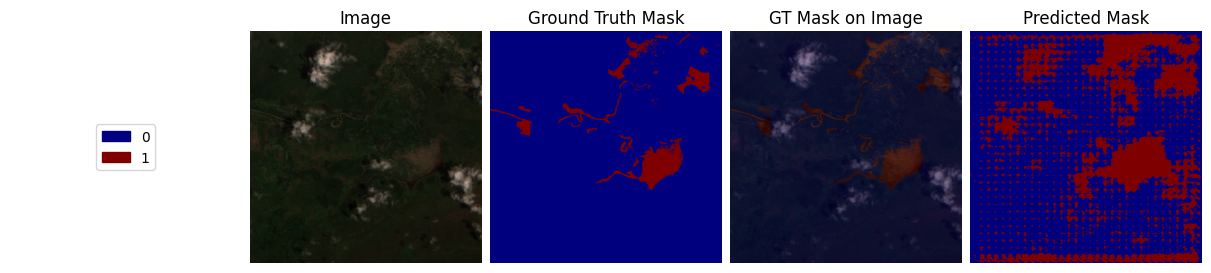

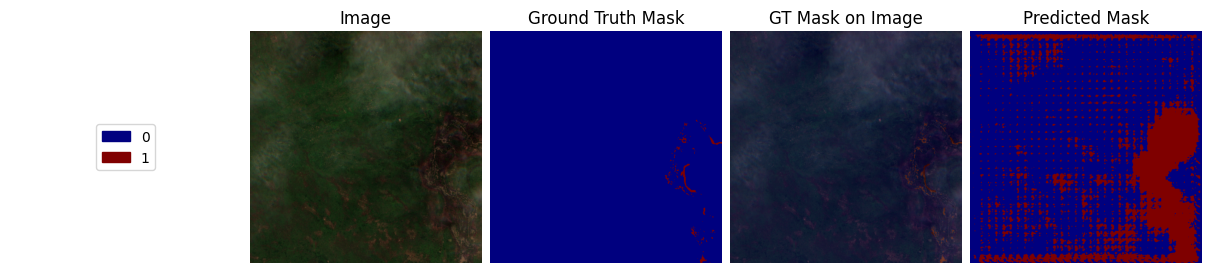

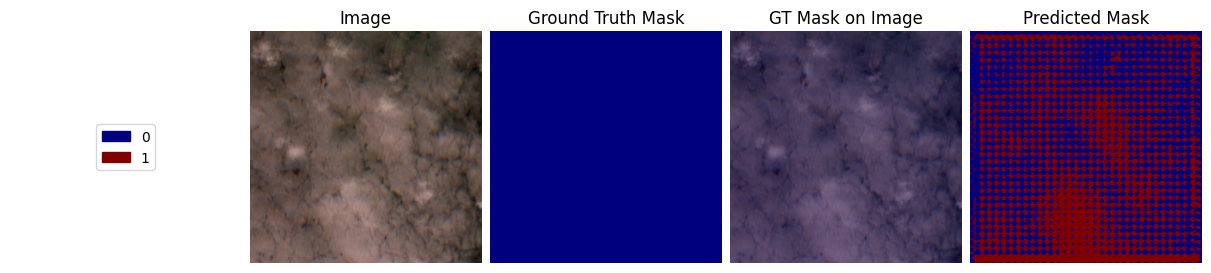

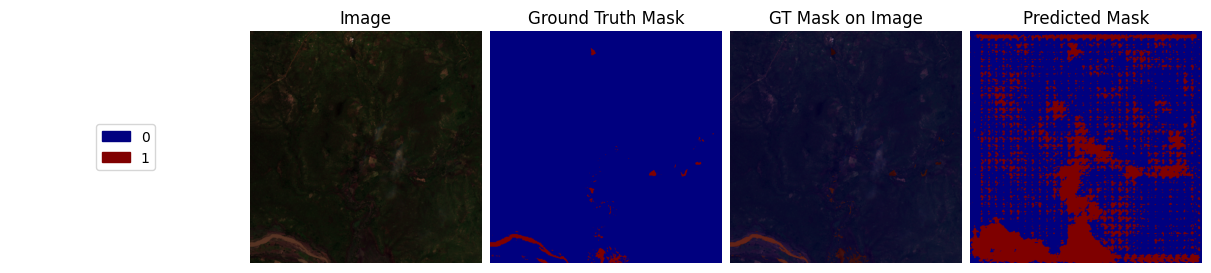

In [21]:
# Now we can use the model for predictions and plotting
model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
)

test_loader = datamodule.test_dataloader()
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"]
    for mod, value in images.items():
        images[mod] = value.to(model.device)
    masks = batch["mask"].numpy()

    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(4):
    sample = {
        "image": batch["image"]["S2L1C"][i].cpu(),
        "mask": batch["mask"][i],
        "prediction": preds[i],
    }
    test_dataset.plot(sample)
    plt.show()

# Note: This demo only trains for 5 epochs by default, which does not result in good predictions.

# Fine-tuning via CLI

We also run the fine-tuning via a [CLI](https://ibm.github.io/terratorch/stable/quick_start/#training-with-lightning-tasks). All parameters we have specified in the notebook can be put in a [yaml]( ../configs/terramind_v1_base_sen1floods11.yaml), and can be run using the command below. Take a look at the [TerraTorch docs](https://ibm.github.io/terratorch/stable/tutorials/the_yaml_config/) for how to setup the config.

In [22]:
# First let's get the config files from github.com.
!git init
!git remote add origin https://github.com/IBM/ML4EO-workshop-2025.git
!git fetch --all
!git checkout origin/main -- "TerraMind/configs/terramind_v1_base_sen1floods11.yaml"
!git checkout origin/main -- "TerraMind/configs/terramind_v1_base_tim_lulc_sen1floods11.yaml"

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Fetching origin
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 76 (delta 21), reused 72 (delta 21), pack-reused 0 (from 0)
Unpacking objects: 100% (76/76), 4.91 MiB | 7.30 MiB/s, done.
From https://github.com/IBM/ML4EO-workshop-2025
 * [new branch]      main       -> origin/main


In [23]:
# Run fine-tuning
!terratorch fit -c "TerraMind/configs/terramind_v1_base_sen1floods11.yaml"

2025-06-20 12:58:31.281463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750424311.534037    3630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750424311.601388    3630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/cli.py:683: `SemanticSegmentationTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Using default `ModelCheckpoint`. Consider 

In [1]:
# Run Thinking-in-Modalities (TiM) with generated LULC tokens
!terratorch fit -c "TerraMind/configs/terramind_v1_base_tim_lulc_sen1floods11.yaml"

2025-06-20 13:15:17.274520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750425317.628584    7888 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750425317.706810    7888 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-20 13:15:18.321582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/ligh